# Лабораторная работа 3. Прогнозирование с помощью моделей ARIMA и их модификаций

## Подготовка данных

In [1]:
import pandas as pd

data = pd.read_excel("salary_rus.ods", engine='odf')

In [2]:
data_melted = data.melt(id_vars=["Unnamed: 0"], var_name="Month", value_name="Salary")
data_melted.columns = ["Year", "Month", "Salary"]

month_map = {
    "Январь": 1, "Февраль": 2, "Март": 3, "Апрель": 4, "Май": 5, 
    "Июнь": 6, "Июль": 7, "Август": 8, "Сентябрь": 9, "Октябрь": 10, 
    "Ноябрь": 11, "Декабрь": 12
}
data_melted["Month"] = data_melted["Month"].map(month_map)
data_melted["Date"] = pd.to_datetime(data_melted[["Year", "Month"]].assign(DAY=1))
data_melted = data_melted.sort_values("Date").set_index("Date")

time_series = data_melted["Salary"]

time_series.head()

Date
1991-01-01    0.308
1991-02-01    0.294
1991-03-01    0.337
1991-04-01    0.373
1991-05-01    0.438
Name: Salary, dtype: float64

## Декомпозиция и визуализация

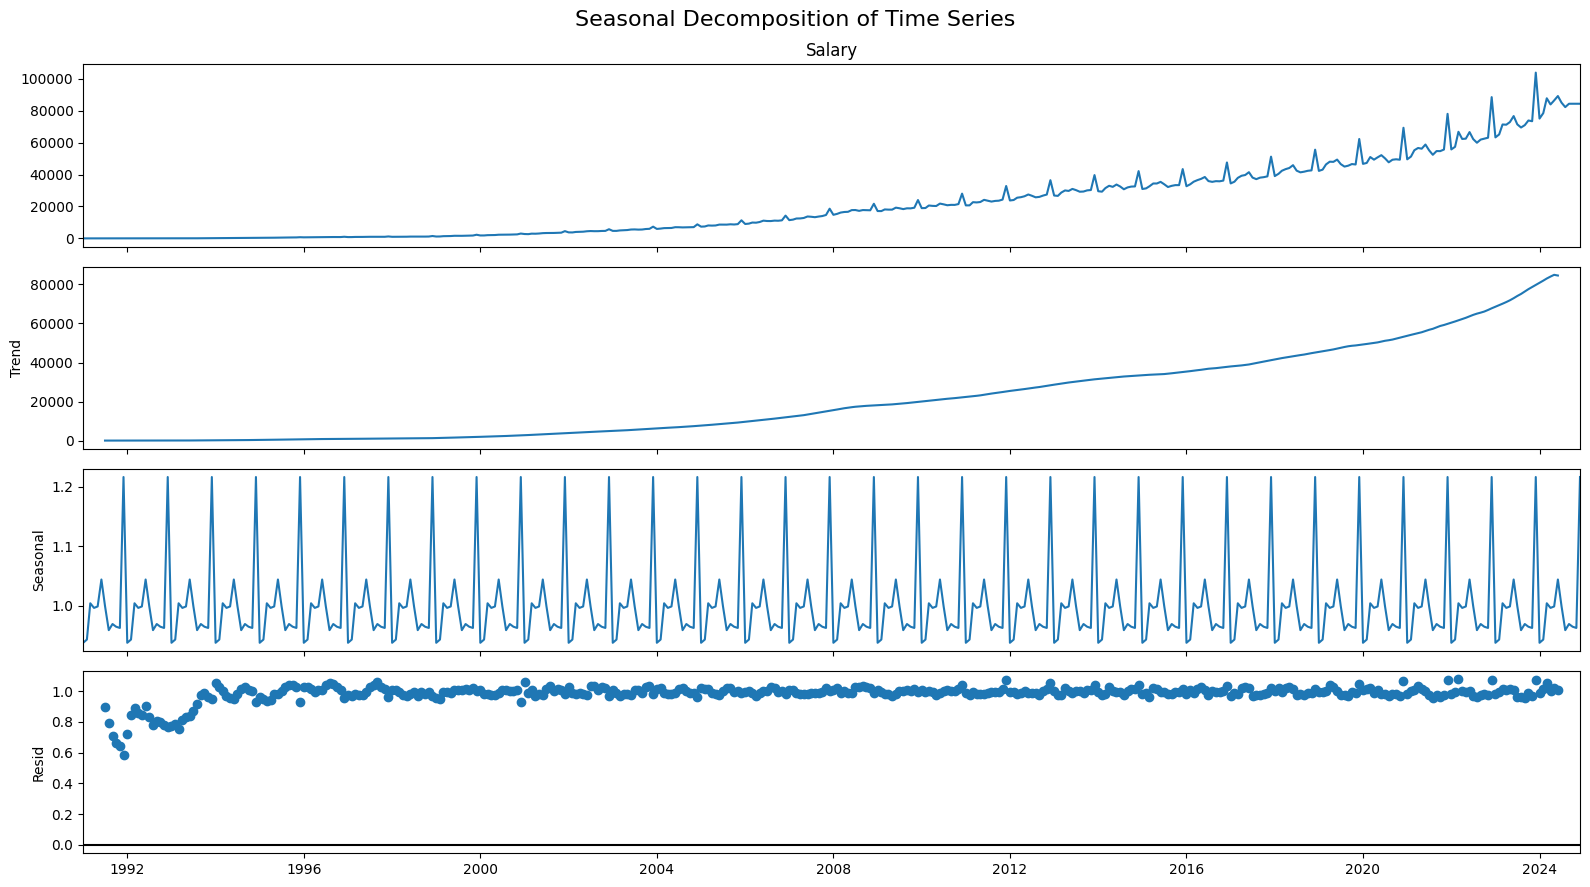

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

time_series_interpolated = time_series.interpolate(method='linear')
decomposition = seasonal_decompose(time_series_interpolated, model='multiplicative', period=12)

fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.suptitle("Seasonal Decomposition of Time Series", fontsize=16)
plt.tight_layout()
plt.show()

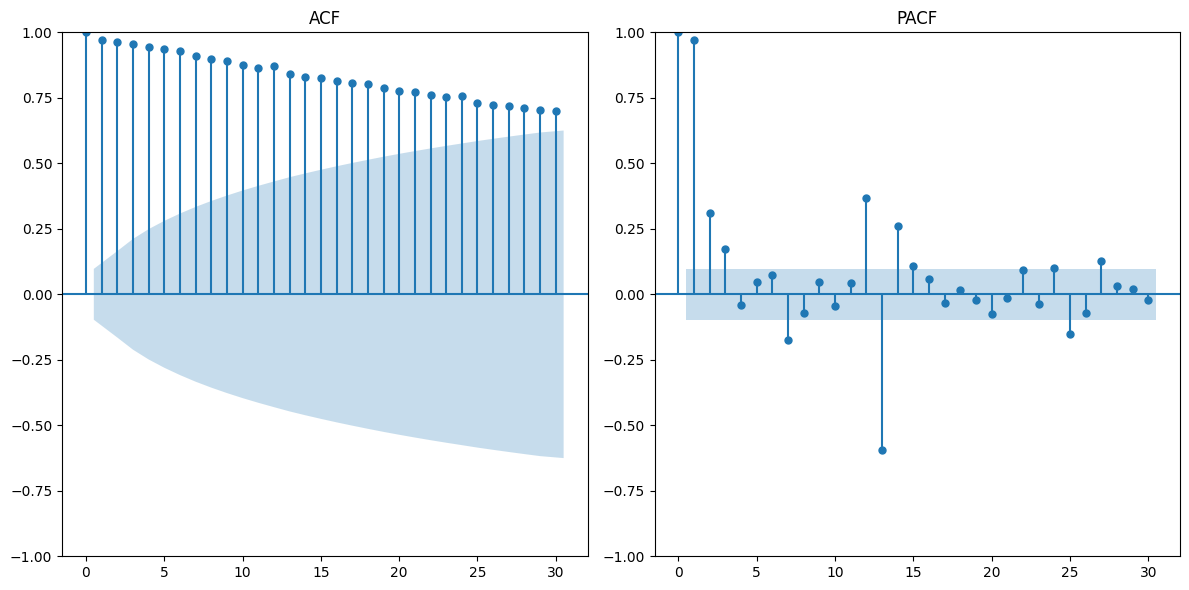

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(time_series_interpolated, lags=30, ax=plt.gca(), title="ACF")

plt.subplot(1, 2, 2)
plot_pacf(time_series_interpolated, lags=30, ax=plt.gca(), title="PACF")

plt.tight_layout()
plt.show()

## Построение модели и анализ точности

/home/udeugene/Documents/ITMO/math-forecast/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


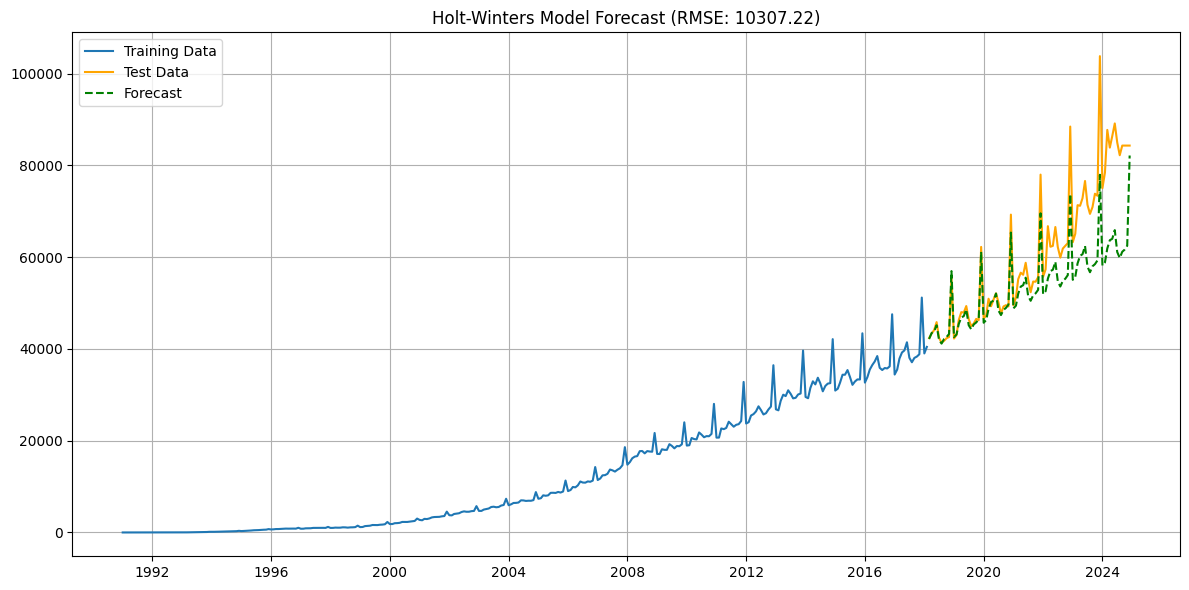

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

split_point = int(len(time_series_interpolated) * 0.8)
train, test = time_series_interpolated[:split_point], time_series_interpolated[split_point:]

hw_model = ExponentialSmoothing(train, seasonal='multiplicative', seasonal_periods=12, trend='additive')
hw_model = hw_model.fit()

forecast = hw_model.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, forecast))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast, label='Forecast', color='green', linestyle='--')
plt.title(f"Holt-Winters Model Forecast (RMSE: {rmse:.2f})")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

/home/udeugene/Documents/ITMO/math-forecast/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/udeugene/Documents/ITMO/math-forecast/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


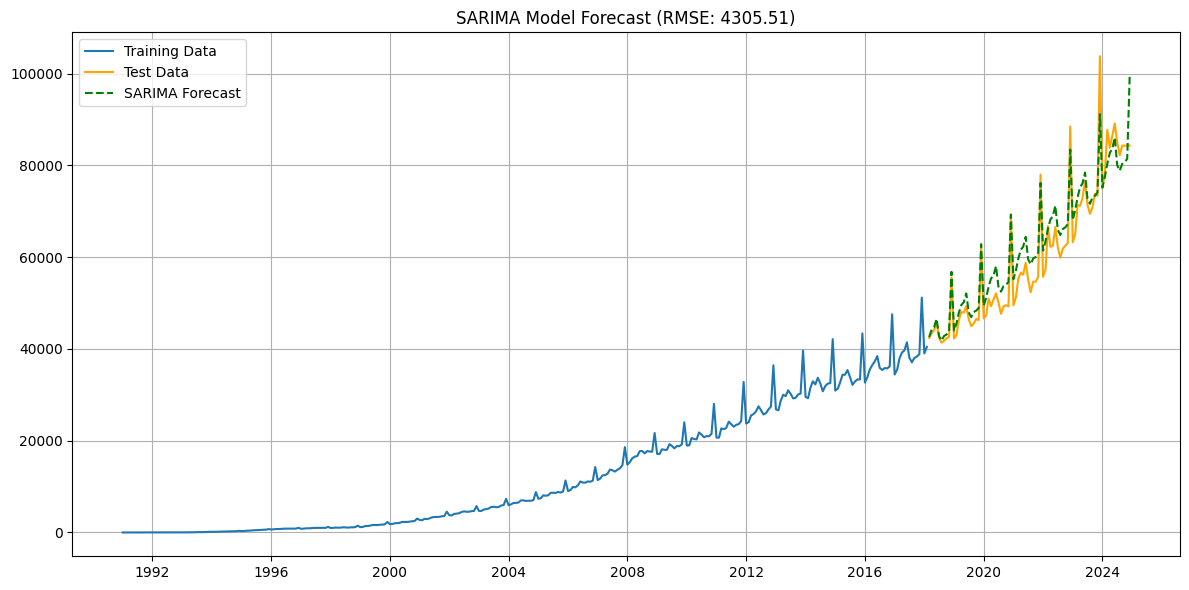

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_order = (2, 1, 1)  # p, d, q
seasonal_order = (1, 1, 1, 12)  # P, D, Q, s

sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model = sarima_model.fit(disp=False)

sarima_forecast = sarima_model.get_forecast(steps=len(test))
sarima_forecast_mean = sarima_forecast.predicted_mean

sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast_mean))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(sarima_forecast_mean, label='SARIMA Forecast', color='green', linestyle='--')
plt.title(f"SARIMA Model Forecast (RMSE: {sarima_rmse:.2f})")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

hw_mae = mean_absolute_error(test, forecast)
hw_mape = mean_absolute_percentage_error(test, forecast)

sarima_mae = mean_absolute_error(test, sarima_forecast_mean)
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast_mean)

metrics_df = pd.DataFrame({
    "Model": ["Holt-Winters", "SARIMA"],
    "RMSE": [rmse, sarima_rmse],
    "MAE": [hw_mae, sarima_mae],
    "MAPE (%)": [hw_mape * 100, sarima_mape * 100],
    "R^2": [r2_score(test, forecast), r2_score(test, sarima_forecast_mean)]
})

metrics_df.round(2)

,Model,RMSE,MAE,MAPE (%),R^2
0,Holt-Winters,10307.22,6781.04,9.18,0.52
1,SARIMA,4305.51,3480.29,5.79,0.92


## Тюнинг с помощью AUTOARIMA

/home/udeugene/Documents/ITMO/math-forecast/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


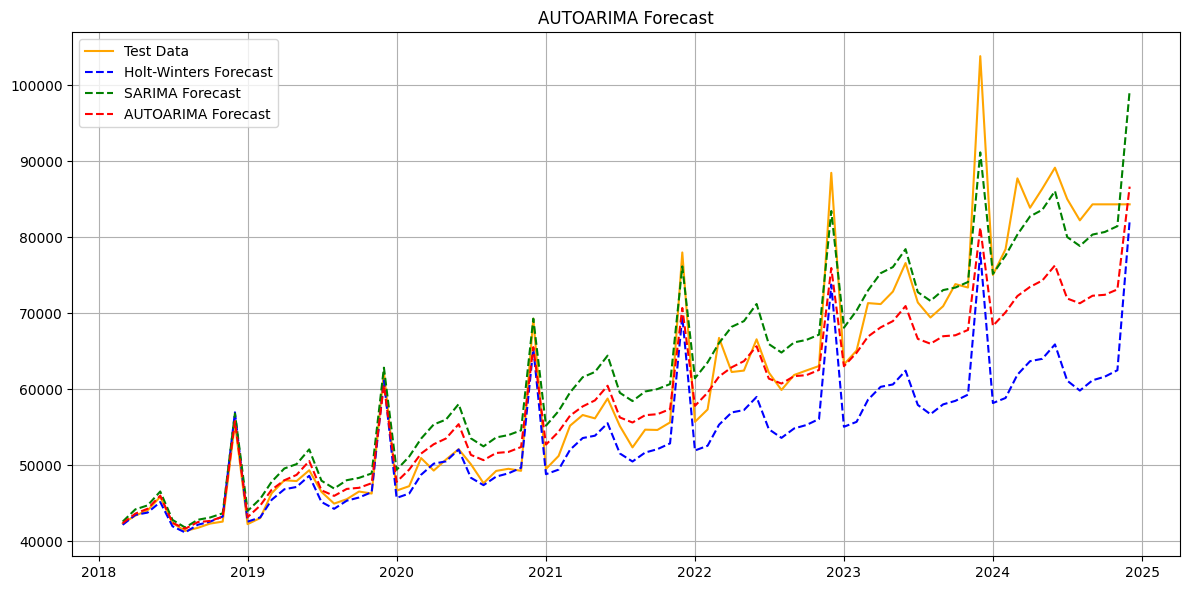

,Model,RMSE,MAE,MAPE (%),R^2
0,Holt-Winters,10307.22,6781.04,9.18,0.52
1,SARIMA,4305.51,3480.29,5.79,0.92
2,AUTOARIMA,5622.64,3573.09,4.98,0.86


In [8]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

data = pd.DataFrame({'unique_id': ['series_1'] * len(train), 'ds': train.index, 'y': train.values})

sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS')
sf.fit(data)
forecast = sf.forecast(df=data, h=len(test), level=[95])

holt_winters_forecast = hw_model.forecast(steps=len(test))
sarima_forecast = sarima_model.get_forecast(steps=len(test)).predicted_mean
auto_arima_forecast = forecast['AutoARIMA']

auto_arima_forecast.index = test.index[:len(auto_arima_forecast)]
holt_winters_forecast.index = test.index[:len(holt_winters_forecast)]
sarima_forecast.index = test.index[:len(sarima_forecast)]

holt_winters_metrics = [
    np.sqrt(mean_squared_error(test, holt_winters_forecast)),
    mean_absolute_error(test, holt_winters_forecast),
    mean_absolute_percentage_error(test, holt_winters_forecast) * 100,
    r2_score(test, holt_winters_forecast)
]

sarima_metrics = [
    np.sqrt(mean_squared_error(test, sarima_forecast)),
    mean_absolute_error(test, sarima_forecast),
    mean_absolute_percentage_error(test, sarima_forecast) * 100,
    r2_score(test, sarima_forecast)
]

auto_arima_metrics = [
    np.sqrt(mean_squared_error(test, auto_arima_forecast)),
    mean_absolute_error(test, auto_arima_forecast),
    mean_absolute_percentage_error(test, auto_arima_forecast) * 100,
    r2_score(test, auto_arima_forecast)
]

metrics_df = pd.DataFrame([
    ["Holt-Winters"] + holt_winters_metrics,
    ["SARIMA"] + sarima_metrics,
    ["AUTOARIMA"] + auto_arima_metrics
], columns=["Model", "RMSE", "MAE", "MAPE (%)", "R^2"])

plt.figure(figsize=(12, 6))
plt.plot(test, label='Test Data', color='orange')
plt.plot(holt_winters_forecast, label='Holt-Winters Forecast', linestyle='--', color='blue')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--', color='green')
plt.plot(auto_arima_forecast, label='AUTOARIMA Forecast', linestyle='--', color='red')
plt.title("AUTOARIMA Forecast")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

metrics_df.round(2)


In [10]:
from statsforecast.arima import arima_string
arima_string(sf.fitted_[0,0].model_)
# sarima_order = (1, 1, 1)  # p, d, q
# seasonal_order = (1, 1, 1, 12)  # P, D, Q, s

'ARIMA(0,1,1)(1,1,2)[12]                   '